In [30]:
from sklearn.mixture import GaussianMixture
import matplotlib as mpl
from src.data import IDAOData, train_transforms, val_transforms
from src import preprocessing
from tqdm.auto import tqdm
import torch
import pandas as pd
import numpy as np
import cv2
import albumentations as A
from importlib import reload
import random
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
random.seed(42)

In [312]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

# Load data

Here we get preloaded raw images for each set. We split initial train folder to train/val/test, but later we haven't used it, so I will treat them all as train.

In [ ]:
# # Run to split initial train
# ! source activate pDL
# ! export PYTHONPATH="$PWD" && python scripts/create_datasets.py

In [3]:
# New directories
data_root = Path("data")

train_dir = data_root / "train"
val_dir = data_root / "val"
test_dir = data_root / "test"
test_holdout_dir = data_root / "test_holdout"
center = 120

In [4]:
# Load datasets
train_ds = IDAOData(train_dir, transform=val_transforms(center))
val_ds = IDAOData(val_dir, )
test_ds = IDAOData(test_dir)
test_holdout_ds = IDAOData(test_holdout_dir, transform=val_transforms(center))
public_test_ds = IDAOData('idao_dataset/public_test', transform=val_transforms(center), is_train=False)
private_test_ds = IDAOData('idao_dataset/private_test', transform=val_transforms(center), is_train=False)

# Create features

We calculate same features for each dataset.   
First, images are normalized using statistics from train.   
Then all negative pixels are clipped to 0. For each image there are 8 features: sqrt of sum of pixels and sqrt variance of distance of "bright blob" from center X 4 center crops of 10, 20, 80, 120 pixels.   
(Distance from center is also a good feature, but we didn't use it for final solution.)   

In [5]:
def get_preprocessed_data():
    crop_dfs = []

    for center in [10, 20, 80, 120]:
        df_list = []
        transforms = val_transforms(center)
        for ds, ds_name in zip([train_ds, val_ds, test_ds, test_holdout_ds, public_test_ds, private_test_ds],
                      ['train', 'train', 'train', 'test_holdout', 'public_test', 'private_test']):
            ds.transform = transforms
            for idx in tqdm(np.arange(len(ds))):
                [img_yx], r_type, energy, img_idx = ds[idx]
                img_yx[img_yx < 0] = 0
                sum_pixels, offset_x, offset_y, sq_dist, var = preprocessing.get_avg_value_and_distance(img_yx)
                out = {
                    'ds_name': ds_name,
                    'img_idx': img_idx, 
                    'r_type': r_type,
                    'energy': energy,
                    f'sqrt_sum_pixels_{center}': np.sqrt(sum_pixels), 
                    f'sqrt_var_{center}': np.sqrt(var),
                }
                df_list.append(out)
        df = pd.DataFrame(df_list)
        crop_dfs.append(df)
    
    df = pd.concat(crop_dfs, axis=1)
    df = df.loc[:, ~df.columns.duplicated()]
    df['class'] = df['r_type'] + df['energy']
    
    return df

In [6]:
df = get_preprocessed_data()

In [7]:
df.head()

,ds_name,img_idx,r_type,energy,sqrt_sum_pixels_10,sqrt_var_10,sqrt_sum_pixels_20,sqrt_var_20,sqrt_sum_pixels_80,sqrt_var_80,sqrt_sum_pixels_120,sqrt_var_120,class
0,train,-0.2627299726009369__CYGNO_60_40_ER_30_keV_930...,1,30,3.936453,3.822017,6.875200,7.041077,24.837458,25.324972,31.116173,38.863424,31
1,train,-2.5678000450134277__CYGNO_60_40_He_NR_1_keV_9...,0,1,2.153423,3.698843,4.131759,7.896950,14.261483,32.448662,21.676035,49.033408,1
2,train,2.466599941253662__CYGNO_60_40_He_NR_1_keV_930...,0,1,1.849169,4.079595,3.735746,8.194039,14.793370,32.295921,22.251701,48.722219,1
3,train,-0.8590999841690063__CYGNO_60_40_He_NR_6_keV_9...,0,6,4.250731,3.826692,6.672314,6.982933,15.673782,30.177404,22.633442,47.298923,6
4,train,-0.8675956726074219__CYGNO_60_40_ER_30_keV_930...,1,30,6.382896,3.684344,10.333701,6.096692,27.131927,22.458788,31.774006,36.583674,31


# Plot

Plot data choosing 2 features.   
Visually, 120 center crops help split classes with higher energy, while 10 center crops help split low energy particles (though it is still pretty hard).

In [138]:
def plot_dist(col_x, col_y, save_nm=None):
    fig, axis = plt.subplots(figsize=(10, 6))

    mask = df['r_type'] == -1
    axis.scatter(df[mask][col_x], 
                df[mask][col_y], 
                 label='Unlabeled', marker='x', c='k', alpha=0.4, s=2)      
    for r_type in [0, 1]:
        for energy in [1, 3, 6, 10, 20, 30]:
    #     for energy in [3, 6]:

            mask = (df['r_type'] == r_type) & (df['energy'] == energy)
            if mask.sum() > 100:
                axis.scatter(df[mask][col_x], df[mask][col_y], 
                             label=f'{r_type} - {energy} - train', alpha=0.6, s=2)
            else:
                axis.scatter(df[mask][col_x], df[mask][col_y], 
                             label=f'{r_type} - {energy} - holdout', alpha=0.9, s=150)


    # axis.set_xlim(0, 20)
    lgd = axis.legend(fontsize='medium', bbox_to_anchor=(1.04,1), loc="upper left")
    axis.set_xlabel(col_x)
    axis.set_ylabel(col_y)
    axis.set_title('Ditribution of train, holdout and private test (Unlabeled) images')
    if save_nm:
        plt.savefig(f'_assets/{save_nm}.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

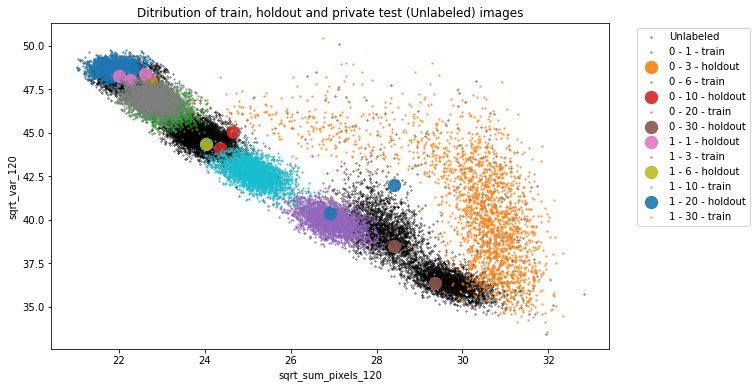

In [139]:
plot_dist('sqrt_sum_pixels_120', 'sqrt_var_120', 'plot_data_crop_120')

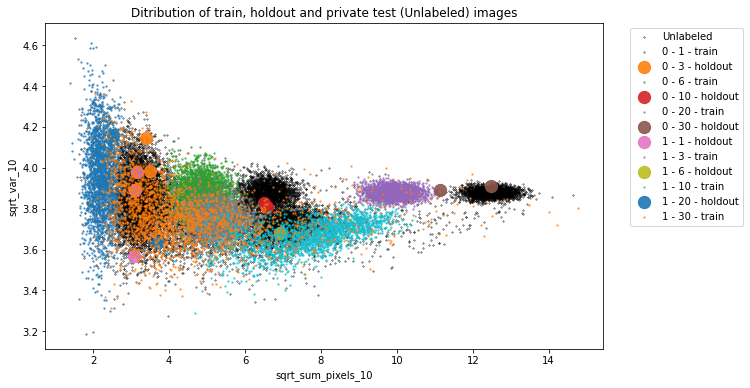

In [140]:
plot_dist('sqrt_sum_pixels_10', 'sqrt_var_10', 'plot_data_crop_10')

# Model

Fit first Gaussian Mixture Model (GMM) to train and predict on public_test.  
Initialize second GMM with holdout data means, fit on unlabeled private test, predict for private test. 

In [35]:
from scripts.baseline import get_clf_metrics, get_reg_metrics

def get_X_y(df):
    X = df.drop(columns=['ds_name', 'img_idx', 'r_type', 'energy', 'class']).values
    y = df['class']
    return X, y

def prob_to_target(prob_n6, type_in_6, ener_6):
    prob_class_n = prob_n6.dot(type_in_6)
    prob_class_n[prob_class_n < 0.5]
    energy_n = ener_6[np.argmax(prob_n6, axis=-1)]
    return prob_class_n, energy_n

def get_submission(estimator, ds_name, type_6, ener_6):
    mask = df['ds_name'] == ds_name
    X_nk, _ = get_X_y(df[mask])
    y_n6 = estimator.predict_proba(X_nk)
    prob_class_n, energy_n = prob_to_target(y_n6, type_6, ener_6)

    dict_pred = dict(id=df[mask]['img_idx'],
                         classification_predictions=prob_class_n,
                         regression_predictions=energy_n)

    return pd.DataFrame(dict_pred)

def SAVE_SUBMISSION(data_frame, suffix):
    data_frame.to_csv(f'_assets/submission{suffix}.csv', index=False, header=True)

In [118]:
# const
uniq_classes_all = np.array([1, 2, 3, 4, 6, 7, 10, 11, 20, 21, 30, 31])
uniq_classes_in  = np.array([1,       4, 6,        11, 20,         31])
uniq_classes_out = np.array([   2, 3,       7, 10,         21, 30,   ])

type_in_6  = np.array([0, 1, 0, 1, 0, 1])
type_out_6 = np.array([1, 0, 1, 0, 1, 0])
ener_6 = np.array([1, 3, 6, 10, 20, 30])

class_to_target = {t + e: (t, e) for t in [0, 1] for e in ener_6}

feature_nm_8 = df.drop(columns=['ds_name', 'img_idx', 'r_type', 'energy', 'class']).columns

In [49]:
# IN distribution = train
# get data
mask = df['ds_name'].isin(['train'])
X_train, y_train = get_X_y(df[mask])
type_train, ener_train = df[mask]['r_type'].values, df[mask]['energy'].values

np.random.seed(21)
# init estimator
estimator_train = GaussianMixture(n_components=6, covariance_type='full', 
                                  max_iter=50)
estimator_train.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                for i in uniq_classes_in])
# fit
estimator_train.fit(X_train)
estimator_train.precisions_cholesky_ /= 2

# predict
y_n6 = estimator_train.predict_proba(X_train)
prob_class_n, energy_n = prob_to_target(y_n6, type_in_6, ener_6)

get_clf_metrics(type_train, prob_class_n), get_reg_metrics(ener_train, energy_n)

({'AUC': 1.0}, {'MAE': 0.019, 'RMSE': 0.582})

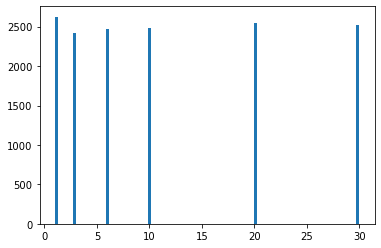

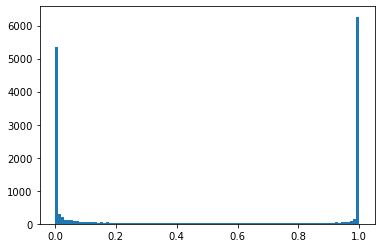

In [103]:
plt.hist(energy_n, bins=101)
plt.show()

plt.hist(prob_class_n, bins=101)
plt.show()

In [104]:
# OUT of distribution = private test
# get data
mask = df['ds_name'].isin(['private_test'])
X_test, _ = get_X_y(df[mask])

# OUT SAMPLE
# get data
mask = df['ds_name'].isin(['test_holdout'])
X_test_holdout, y_test_holdout = get_X_y(df[mask])
type_test_holdout, ener_test_holdout = df[mask]['r_type'].values, df[mask]['energy'].values



np.random.seed(21)
# init estimator WITH TRAIN MEANS
estimator = GaussianMixture(n_components=6, covariance_type='full', 
                                  max_iter=50)

# estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
#                                 for i in uniq_classes_in])

estimator.means_init = np.array([X_test_holdout[y_test_holdout == i].mean(axis=0)
                                for i in uniq_classes_out])
# fit
estimator.fit(X_test)


estimator.precisions_cholesky_[0] /= np.e
# estimator.precisions_cholesky_ /= 2
# estimator.precisions_cholesky_[1] /= 6


# predict
y_holdout_n6 = estimator.predict_proba(X_test_holdout)
prob_class_holdout_n, energy_holdout_n = prob_to_target(y_holdout_n6, type_out_6, ener_6)

y_n6 = estimator.predict_proba(X_test)
prob_class_n, energy_n = prob_to_target(y_n6, type_out_6, ener_6)

get_clf_metrics(type_test_holdout, prob_class_holdout_n), get_reg_metrics(ener_test_holdout, energy_holdout_n)

({'AUC': 1.0}, {'MAE': 0.333, 'RMSE': 0.816})

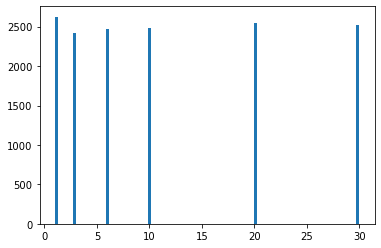

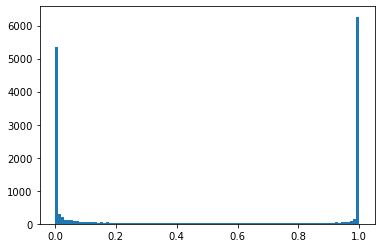

In [105]:
plt.hist(energy_n, bins=101)
plt.show()

plt.hist(prob_class_n, bins=101)
plt.show()

In [70]:
# # Save submission
# df_results = pd.concat([get_submission(estimator_train, 'public_test', type_in_6, ener_6),
#                         get_submission(estimator, 'private_test', type_out_6, ener_6)])
# SAVE_SUBMISSION(df_results, '_GMM')

In [464]:
%matplotlib notebook

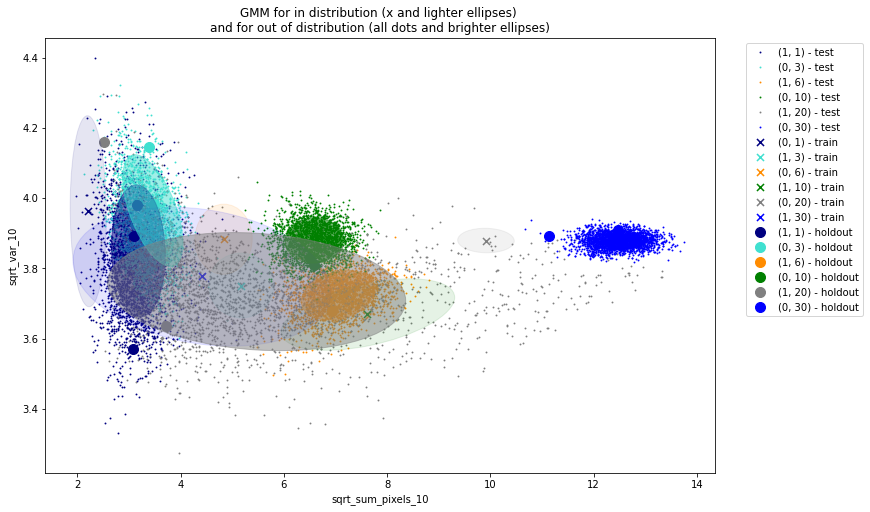

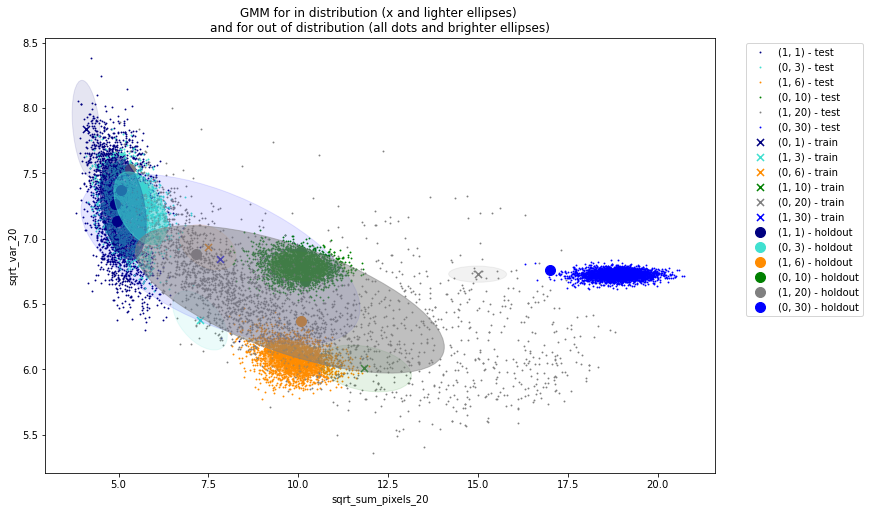

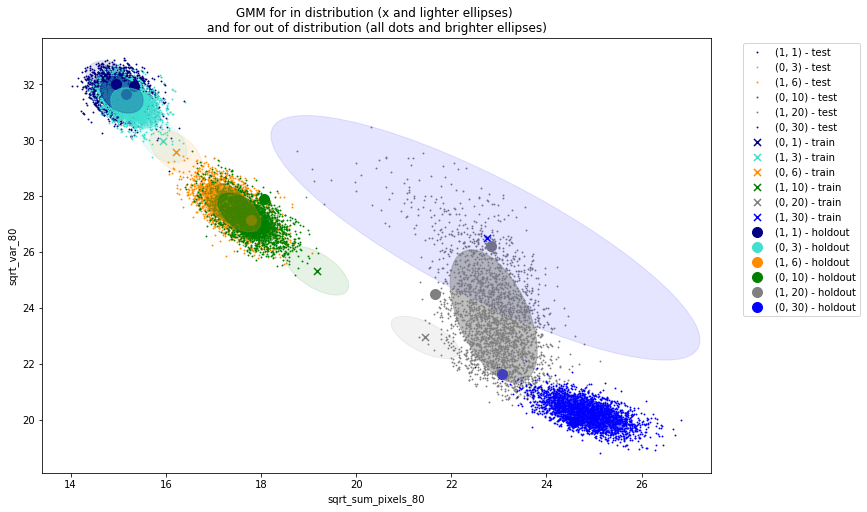

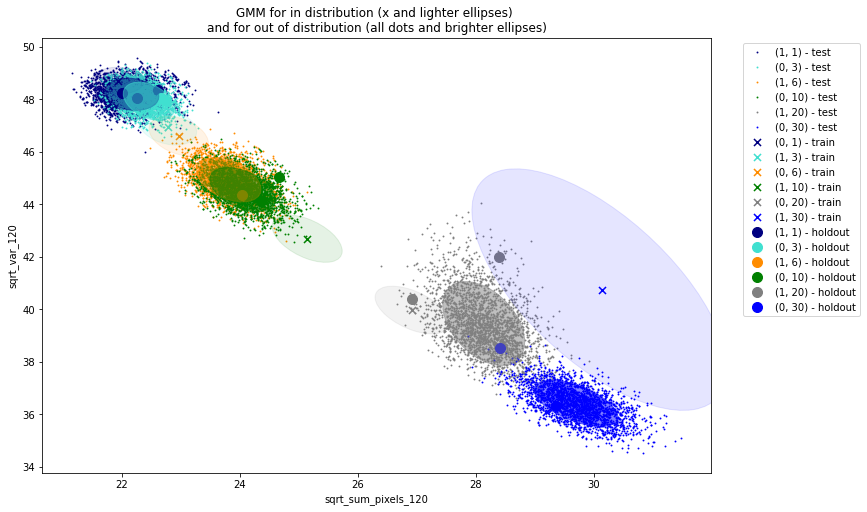

In [143]:


colors = ['navy', 'turquoise', 'darkorange', 'green', 'grey', 'blue', 'navy', 'turquoise', 'darkorange', 'green', 'grey', 'blue', ]


def make_ellipses(gmm, ax, label='', alpha=0.5):
    for n, color in enumerate(colors[:estimator.n_components]):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][components_2][:, components_2]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, components_2], v[0], v[1],
                                  180 + angle, color=color, )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(alpha)
        ax.add_artist(ell)

        
        
for plot_idx, components_2 in enumerate([
    [0,  1],  
    [2, 3], 
    [4, 5], 
    [6, 7]
]):
    
    fig, axis = plt.subplots(figsize=(12, 8))
    make_ellipses(estimator_train, axis, 'train', alpha=0.1)
    make_ellipses(estimator, axis, 'test')
    
#     for n, color in enumerate(colors[:6]):
#         data = X_train[y_train == uniq_classes_in[n]]
#         plt.scatter(data[:, components_2[0]], data[:, components_2[1]],
#                     s=0.8, color=color,
#                     label=class_to_target[uniq_classes_in[n]])

    for n, color in enumerate(colors[:6]):
        y_n6 = estimator.predict_proba(X_test)
        data = X_test[y_n6.argmax(-1) == np.arange(6)[n]]
        plt.scatter(data[:, components_2[0]], data[:, components_2[1]],
                    s=0.8, color=color,
                    label=f'{class_to_target[uniq_classes_out[n]]} - test')


    for i, color in enumerate(colors[6:]):
        plt.scatter(estimator_train.means_init[i, components_2[0]],
                    estimator_train.means_init[i, components_2[1]],
                    label=f'{class_to_target[uniq_classes_in[i]]} - train', 
                    s=50, color=color, marker='x')
    
    
    
#     data = X_test
#     slc = slice(None)
#     plt.scatter(data[slc, components_2[0]], data[slc, components_2[1]],
#                 s=0.1, color='k',label='test')
    
    for n, color in enumerate(colors[6:]):
        data = X_test_holdout[y_test_holdout == uniq_classes_out[n]]
        plt.scatter(data[:, components_2[0]], data[:, components_2[1]],
                    s=100, color=color,
                    label=f'{class_to_target[uniq_classes_out[n]]} - holdout')

    lgd = axis.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    f_nm_x, f_nm_y = feature_nm_8[components_2[0]], feature_nm_8[components_2[1]]
    axis.set_xlabel(f_nm_x)
    axis.set_ylabel(f_nm_y)
    axis.set_title('GMM for in distribution (x and lighter ellipses) \nand for out of distribution (all dots and brighter ellipses)')
    plt.savefig(f'_assets/prediction_{f_nm_x}_{f_nm_y}.png', bbox_extra_artists=(lgd,), bbox_inches='tight')